In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import timm
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import StepLR
import numpy as np

In [15]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to your dataset (Google Drive)
BASE_PATH = "/content/drive/MyDrive/Solo(ds) Projects/Binary Classification using Diffusion Model"
CATS_PATH = os.path.join(BASE_PATH, "animals/cats")
DOGS_PATH = os.path.join(BASE_PATH, "animals/dogs")
NEITHER_PATH = os.path.join(BASE_PATH, "neither")

Epoch [1/5], Loss: 0.3296
Epoch [2/5], Loss: 0.1313
Epoch [3/5], Loss: 0.1479
Epoch [4/5], Loss: 0.1386
Epoch [5/5], Loss: 0.1643


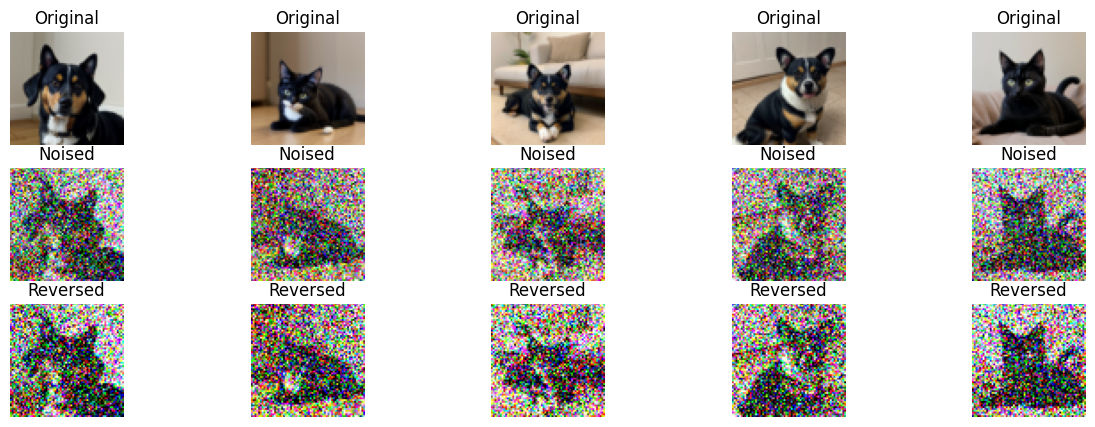

Training Classifier (Epoch 1/5): 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Epoch [1/5], Loss: 0.6494, Accuracy: 70.00%


Training Classifier (Epoch 2/5): 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Epoch [2/5], Loss: 0.3402, Accuracy: 84.38%


Training Classifier (Epoch 3/5): 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Epoch [3/5], Loss: 0.2212, Accuracy: 90.88%


Training Classifier (Epoch 4/5): 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


Epoch [4/5], Loss: 0.1405, Accuracy: 96.12%


Training Classifier (Epoch 5/5): 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

Epoch [5/5], Loss: 0.0812, Accuracy: 98.62%


In [16]:
# Dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, cats_path, dogs_path, transform=None):
        self.cats_path = cats_path
        self.dogs_path = dogs_path
        self.transform = transform
        self.data = []
        self.labels = []

        # Load cat images
        for img in os.listdir(cats_path):
            self.data.append(os.path.join(cats_path, img))
            self.labels.append(0)  # 0 for cats

        # Load dog images
        for img in os.listdir(dogs_path):
            self.data.append(os.path.join(dogs_path, img))
            self.labels.append(1)  # 1 for dogs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Dataset and DataLoader
dataset = CatsDogsDataset(CATS_PATH, DOGS_PATH, transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Diffusion forward function
def diffusion_forward(x, t, noise):
    """
    Applies forward diffusion step.
    x: Original image tensor.
    t: Time step tensor (broadcastable to x).
    noise: Noise tensor (same shape as x).
    """
    return torch.sqrt(1 - t) * x + torch.sqrt(t) * noise

# Diffusion reverse function
def diffusion_reverse(x, t):
    """
    Applies reverse diffusion step.
    x: Noised image tensor.
    t: Time step tensor.
    """
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, dtype=torch.float32).to(x.device)
    return x / torch.sqrt(1 - t)

# Simple diffusion model
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

diffusion_model = DiffusionModel().to(device)

# Training the diffusion model
def train_diffusion():
    optimizer = optim.Adam(diffusion_model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    epochs = 5

    for epoch in range(epochs):
        for images, _ in train_loader:
            images = images.to(device)
            noise = torch.randn_like(images).to(device)
            t = torch.rand(images.size(0), 1, 1, 1).to(device)

            # Forward diffusion
            noised_images = diffusion_forward(images, t, noise)
            outputs = diffusion_model(noised_images)

            # Compute loss and update weights
            loss = criterion(outputs, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

train_diffusion()

# Visualize diffusion process
def visualize_diffusion():
    images, _ = next(iter(test_loader))
    images = images[:5].to(device)
    noise = torch.randn_like(images).to(device)
    t = torch.tensor(0.5).to(device)

    noised_images = diffusion_forward(images, t, noise)
    reversed_images = diffusion_reverse(noised_images, t)

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(3, 5, i + 6)
        plt.imshow(noised_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        plt.title("Noised")
        plt.axis("off")

        plt.subplot(3, 5, i + 11)
        plt.imshow(reversed_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        plt.title("Reversed")
        plt.axis("off")

    plt.show()

visualize_diffusion()

# Classification model
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)

classification_model = ClassificationModel().to(device)

# Training classification model
def train_classification(num_epochs=5):
    classification_model.train()
    optimizer = optim.Adam(classification_model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.7)  # Fixed scheduler
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        correct = 0
        total = 0
        total_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Training Classifier (Epoch {epoch + 1}/{num_epochs})"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classification_model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        scheduler.step()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

train_classification()

# Prediction on a new image
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    output = classification_model(image)
    _, predicted = torch.max(output, 1)
    return "Dog" if predicted.item() == 1 else "Cat"

In [ ]:
from PIL import Image

# Function to classify a user-provided image
def classify_user_image():
    # Ask the user to provide the image path
    image_path = input("Please enter the full path to the image: ").strip()
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Perform classification
        classification_model.eval()
        with torch.no_grad():
            output = classification_model(image)
            _, predicted = torch.max(output, 1)

        # Map the prediction to a label
        classes = ["Cat", "Dog", "Neither"]
        print(f"The uploaded image is classified as: {classes[predicted.item()]}")
    except Exception as e:
        print(f"Error: {e}\nPlease make sure the file path is correct and the file is a valid image.")

# Call the function to classify an uploaded image
classify_user_image()

Please enter the full path to the image: /content/drive/MyDrive/Solo(ds) Projects/Binary Classification using Diffusion Model/animals/dogs/00502-3846168664.png
The uploaded image is classified as: Dog
